In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D

In [3]:
!7z x Original.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 102445817 bytes (98 MiB)

Extracting archive: Original.zip
--
Path = Original.zip
Type = zip
Physical Size = 102445817

  0%     19% 522 - Original/train/blast/id_dppj7na133.jpg                                                  34% 903 - Original/train/blast/id_nkyu5tm2bm.jpg                                                  46% 1237 - Original/train/blast/id_wptnnoamso.jpg                                                  

In [6]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 29.2 MB/s 
     |████████████████████████████████| 1.6 MB 60.3 MB/s 


In [4]:
train_generator = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=10,
        horizontal_flip=True
    
)

In [7]:
train_data = train_generator.flow_from_directory(
        "/content/Original/train",
        target_size=(256, 256),
        class_mode="sparse",
       
)

Found 2402 images belonging to 3 classes.


In [8]:
train_data.class_indices

{'blast': 0, 'brown': 1, 'healthy': 2}

In [9]:
class_names = list(train_data.class_indices.keys())
class_names 

['blast', 'brown', 'healthy']

In [10]:
val_generator = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=10,
        horizontal_flip=True
    
)

In [11]:
val_data = val_generator.flow_from_directory(
        "/content/Original/val",
        target_size=(256, 256),
        class_mode="sparse",
       
)

Found 268 images belonging to 3 classes.


In [16]:
def build_model(hp):

    model = Sequential()
    
    counter = 0
    
    for i in range(hp.Int('num_layers', min_value = 1 , max_value = 5 )):
        
        if(counter == 0):
        
            model.add(Conv2D(filters = hp.Int('conv_filter'+str(i), min_value = 32 , max_value = 512, step = 32) , kernel_size=  hp.Choice('conv_kernel'+str(i), values = [3,5]) , activation = hp.Choice('activation'+str(i) , values = ['relu', 'tanh']), input_shape = ( 256 , 256, 3), padding= hp.Choice('Padding'+str(i), values= ['same', 'valid']) ))
            model.add(MaxPooling2D(pool_size = hp.Choice('MaxPooling'+str(i) , values = [2, 3]) ))

            model.add(Dropout(hp.Choice('Dropout'+str(i), values = [0.1, 0.2, 0.3, 0.4 , 0.5, 0.6, 0.7, 0.8, 0.9])))
            
        else:
            model.add(Conv2D(filters = hp.Int('conv_filter'+str(i), min_value = 32 , max_value = 512, step = 32) , kernel_size=  hp.Choice('conv_1_kernel'+str(i), values = [3,5]) , activation = hp.Choice('activation'+str(i) , values = ['relu', 'tanh']), input_shape = ( 256 , 256, 3),  padding= hp.Choice('Padding'+str(i), values= ['same', 'valid']) ))
            model.add(MaxPooling2D(pool_size = hp.Choice('MaxPooling'+str(i) , values = [2, 3]) ))

            model.add(Dropout(hp.Choice('Dropout'+str(i), values = [0.1, 0.2, 0.3, 0.4 , 0.5, 0.6, 0.7, 0.8, 0.9])))

        counter += 1

    model.add(Flatten())
    
    model.add(Dense(units = hp.Int('dense_1_units', min_value = 32, max_value= 512, step = 8 ),
        activation = hp.Choice('activationDense' , values = ['relu', 'tanh'])))
    
    model.add(Dense(3 , activation="softmax"))

    model.compile(optimizer= hp.Choice('optimizer', values = ['adam', 'adadelta', 'rmsprop', 'sgd', 'adagrad']) , loss= "sparse_categorical_crossentropy", metrics=['accuracy'])

    return model

In [13]:
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [19]:
tuner = RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials = 5 , directory='output', project_name="Rice Disease Classification1")

In [20]:
tuner.search(train_data , epochs = 5, validation_data = val_data)

Trial 5 Complete [00h 05m 18s]
val_accuracy: 0.6343283653259277

Best val_accuracy So Far: 0.6753731369972229
Total elapsed time: 00h 25m 18s


In [21]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 3,
 'conv_filter0': 352,
 'conv_kernel0': 3,
 'activation0': 'tanh',
 'Padding0': 'same',
 'MaxPooling0': 2,
 'Dropout0': 0.3,
 'dense_1_units': 392,
 'activationDense': 'relu',
 'optimizer': 'sgd',
 'conv_filter1': 32,
 'conv_1_kernel1': 3,
 'activation1': 'relu',
 'Padding1': 'same',
 'MaxPooling1': 2,
 'Dropout1': 0.1,
 'conv_filter2': 32,
 'conv_1_kernel2': 3,
 'activation2': 'relu',
 'Padding2': 'same',
 'MaxPooling2': 2,
 'Dropout2': 0.1}

In [22]:
model = tuner.get_best_models(num_models= 1)[0]

In [23]:

model.fit(train_data , validation_data = val_data , epochs = 200 )

Epoch 1/200
76/76 [==============================] - 52s 679ms/step - loss: 0.8603 - accuracy: 0.6295 - val_loss: 0.8379 - val_accuracy: 0.6306
Epoch 2/200
76/76 [==============================] - 52s 677ms/step - loss: 0.8358 - accuracy: 0.6449 - val_loss: 0.8448 - val_accuracy: 0.6642
Epoch 3/200
76/76 [==============================] - 51s 665ms/step - loss: 0.8233 - accuracy: 0.6507 - val_loss: 0.8158 - val_accuracy: 0.6791
Epoch 4/200
76/76 [==============================] - 52s 685ms/step - loss: 0.8122 - accuracy: 0.6507 - val_loss: 0.9205 - val_accuracy: 0.5784
Epoch 5/200
76/76 [==============================] - 51s 665ms/step - loss: 0.7984 - accuracy: 0.6607 - val_loss: 0.8292 - val_accuracy: 0.6791
Epoch 6/200
76/76 [==============================] - 51s 675ms/step - loss: 0.7812 - accuracy: 0.6674 - val_loss: 0.8455 - val_accuracy: 0.6157
Epoch 7/200
76/76 [==============================] - 51s 663ms/step - loss: 0.7645 - accuracy: 0.6761 - val_loss: 0.7907 - val_accuracy:

In [32]:
model.save_weights('/content/drive/MyDrive/Research Project/my_checkpoint')

In [40]:
model.save("/content/drive/MyDrive/Research Project/keras_tuner.h5")

In [50]:
model.history.history

{'loss': [0.8602870106697083,
  0.8357624411582947,
  0.8233457803726196,
  0.8122019171714783,
  0.7984296679496765,
  0.7811650037765503,
  0.7644854187965393,
  0.7508349418640137,
  0.7469046115875244,
  0.7298447489738464,
  0.7078355550765991,
  0.7018722295761108,
  0.6892105937004089,
  0.6721059679985046,
  0.6702840924263,
  0.6680664420127869,
  0.6286078095436096,
  0.626579225063324,
  0.6258754730224609,
  0.8166041970252991,
  0.6728940010070801,
  0.6124241948127747,
  0.6011964678764343,
  0.602186381816864,
  0.6405707001686096,
  0.5569860339164734,
  0.524554967880249,
  0.5184676051139832,
  0.519271969795227,
  0.4964136779308319,
  0.8093066811561584,
  0.6750855445861816,
  0.5543249249458313,
  0.5518945455551147,
  0.5024639368057251,
  0.47144389152526855,
  0.47590091824531555,
  0.5357959866523743,
  0.4107392728328705,
  0.39739304780960083,
  0.3936152756214142,
  0.3718676269054413,
  0.36422693729400635,
  0.35974180698394775,
  0.8240465521812439,
  0.

In [51]:
model.history.history['val_accuracy']

[0.6305969953536987,
 0.6641790866851807,
 0.6791045069694519,
 0.5783582329750061,
 0.6791045069694519,
 0.6156716346740723,
 0.6753731369972229,
 0.7014925479888916,
 0.6902984976768494,
 0.7276119589805603,
 0.7276119589805603,
 0.7126865386962891,
 0.75,
 0.7089552283287048,
 0.7201492786407471,
 0.7276119589805603,
 0.6865671873092651,
 0.7052238583564758,
 0.7611940503120422,
 0.7052238583564758,
 0.7313432693481445,
 0.7388059496879578,
 0.7164179086685181,
 0.6940298676490784,
 0.7052238583564758,
 0.753731369972229,
 0.7388059496879578,
 0.7649253606796265,
 0.7835820913314819,
 0.8022388219833374,
 0.6828358173370361,
 0.7425373196601868,
 0.7611940503120422,
 0.7313432693481445,
 0.8059701323509216,
 0.7649253606796265,
 0.7910447716712952,
 0.7611940503120422,
 0.7798507213592529,
 0.7873134613037109,
 0.7574626803398132,
 0.746268630027771,
 0.8022388219833374,
 0.8283582329750061,
 0.6791045069694519,
 0.75,
 0.7910447716712952,
 0.7873134613037109,
 0.7985074520111084,
 

In [52]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [55]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

In [56]:
val_acc

[0.6305969953536987,
 0.6641790866851807,
 0.6791045069694519,
 0.5783582329750061,
 0.6791045069694519,
 0.6156716346740723,
 0.6753731369972229,
 0.7014925479888916,
 0.6902984976768494,
 0.7276119589805603,
 0.7276119589805603,
 0.7126865386962891,
 0.75,
 0.7089552283287048,
 0.7201492786407471,
 0.7276119589805603,
 0.6865671873092651,
 0.7052238583564758,
 0.7611940503120422,
 0.7052238583564758,
 0.7313432693481445,
 0.7388059496879578,
 0.7164179086685181,
 0.6940298676490784,
 0.7052238583564758,
 0.753731369972229,
 0.7388059496879578,
 0.7649253606796265,
 0.7835820913314819,
 0.8022388219833374,
 0.6828358173370361,
 0.7425373196601868,
 0.7611940503120422,
 0.7313432693481445,
 0.8059701323509216,
 0.7649253606796265,
 0.7910447716712952,
 0.7611940503120422,
 0.7798507213592529,
 0.7873134613037109,
 0.7574626803398132,
 0.746268630027771,
 0.8022388219833374,
 0.8283582329750061,
 0.6791045069694519,
 0.75,
 0.7910447716712952,
 0.7873134613037109,
 0.7985074520111084,
 

In [57]:
acc

[0.6294754147529602,
 0.6448792815208435,
 0.6507077217102051,
 0.6507077217102051,
 0.6606994271278381,
 0.6673605442047119,
 0.6761032342910767,
 0.6877601742744446,
 0.6877601742744446,
 0.6977518796920776,
 0.7085762023925781,
 0.6998334527015686,
 0.7069109082221985,
 0.7285595536231995,
 0.7264779210090637,
 0.7260616421699524,
 0.7493755221366882,
 0.7502081394195557,
 0.7497918605804443,
 0.6831806898117065,
 0.7206494808197021,
 0.7477102279663086,
 0.7568692564964294,
 0.7626977562904358,
 0.7510408163070679,
 0.7772689461708069,
 0.7880932688713074,
 0.7985012531280518,
 0.7935054302215576,
 0.7993338704109192,
 0.7622814178466797,
 0.7194005250930786,
 0.7781015634536743,
 0.765612006187439,
 0.8014155030250549,
 0.8105745315551758,
 0.8068276643753052,
 0.8155703544616699,
 0.8434637784957886,
 0.8488759398460388,
 0.8522064685821533,
 0.8630307912826538,
 0.868442952632904,
 0.8584513068199158,
 0.8026644587516785,
 0.7672772407531738,
 0.8018317818641663,
 0.819733560085

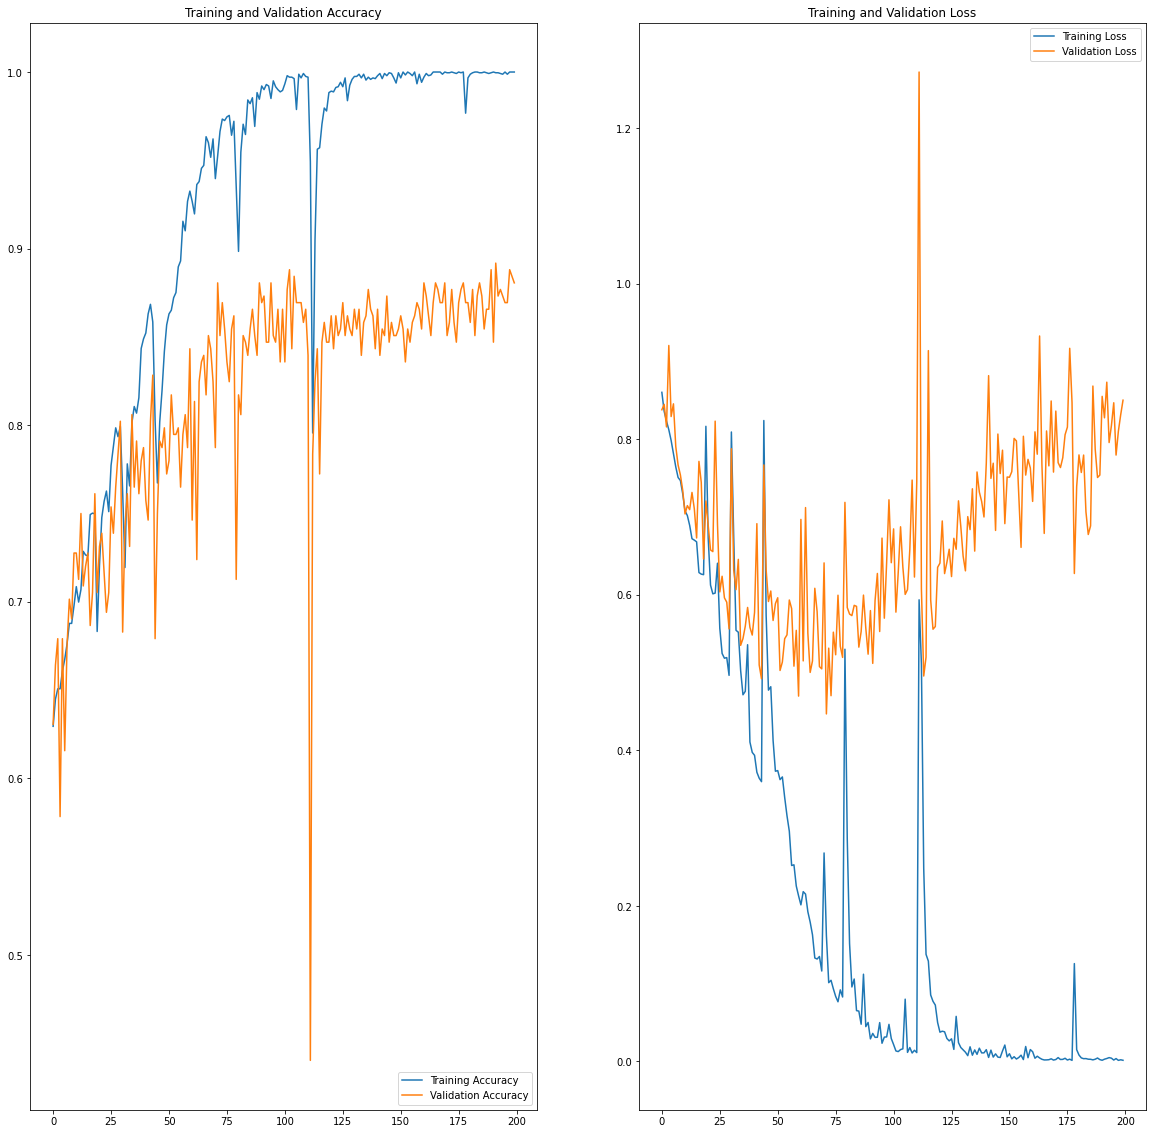

In [58]:
EPOCHS = 200

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
tuner.results_summary()

Results summary
Results in output/Rice Disease Classification1
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 3
conv_filter0: 352
conv_kernel0: 3
activation0: tanh
Padding0: same
MaxPooling0: 2
Dropout0: 0.3
dense_1_units: 392
activationDense: relu
optimizer: sgd
conv_filter1: 32
conv_1_kernel1: 3
activation1: relu
Padding1: same
MaxPooling1: 2
Dropout1: 0.1
conv_filter2: 32
conv_1_kernel2: 3
activation2: relu
Padding2: same
MaxPooling2: 2
Dropout2: 0.1
Score: 0.6753731369972229
Trial summary
Hyperparameters:
num_layers: 3
conv_filter0: 320
conv_kernel0: 3
activation0: tanh
Padding0: same
MaxPooling0: 2
Dropout0: 0.5
dense_1_units: 296
activationDense: relu
optimizer: adagrad
conv_filter1: 352
conv_1_kernel1: 3
activation1: relu
Padding1: valid
MaxPooling1: 3
Dropout1: 0.6
conv_filter2: 224
conv_1_kernel2: 5
activation2: relu
Padding2: valid
MaxPooling2: 3
Dropout2: 0.7
Score: 0.6343283653259277
Trial summary
Hyperparameters:
num_layers: 3
conv_filter0: 384
conv_kern